# 0. Business Goal

The objective is to analyze customer behavior and needs through customer segmentation and cluster similar customers based on their purchasing patterns. This study aims to not only analyze the customer purchase patterns, but also predict their behavior. Using these insights, I strive to build a recommendation system - item based collaborative filtering to enhance user engagement and identify potential purchases.

Conducting customer segmentation will be based on RFM(Recency, Frequency, and Monetary) and K-Means Algorithm. The RFM anallysis is executed using transactional dataset for evaluating customers on their purchase behavior. And K-Means is used to identify inherent clusters emerge from the data. This identification will be helpful to set important strategy such as suggesting special offers and products by their segment.

I especially built an item-based collaborative filtering with these reasons. First of all, the dataset has a large number of transactional records with CustomerID - Item - Timestamp structure, while doesn't have much user profile info. However, it has enough data on what users purchased, enabling to interpret, "Customers who bought X also bought Y."


\\

#1. Data Load

In [1]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# data analytics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path

In [ ]:
file_path = '/content/drive/MyDrive/DataScience/e-commerce-customer-behavior-analytics/analytics/data/data.csv'

df = pd.read_csv(file_path, encoding='ISO-8859-1')

In [9]:
file_path = '/content/drive/MyDrive/DataScience/e-commerce-customer-behavior-analytics/analytics/data'
file_path = Path(file_path)

df = pd.read_pickle(file_path/'data_cleaned.pkl')
customer_df = pd.read_pickle(file_path/'customer_df.pkl')

#2. Data Exploring - Overview

This dataset is the online retail dataset by UCI Machine Learning Library. The dataset contains all the transactions occuring between 01/12/2010 to 09/12/2011 for a UK-based and registered non-store online retail.

Here we have a single transaction of each customerID with different descriptions(items), different stock codes, and different countries.

In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [ ]:
# Statistical info for numerical values

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


Inference for Numerical Values

## 2-1. Quantity

- The average value for quantity is 9.55, which seems reasonable.
- However, this feature has a wide range, with a maximum value of 80,995 and a minimum of -80,995. Ordering 80,995 items doesnt seem plausible, and a negative quantity is also questionable. I'll first check the boxplot to determine whether these values are part of a regular pattern or outliers, and decide accordingly.
- Referring to the plot below, these values cleary appear to be outliers and should be handled appropriately.

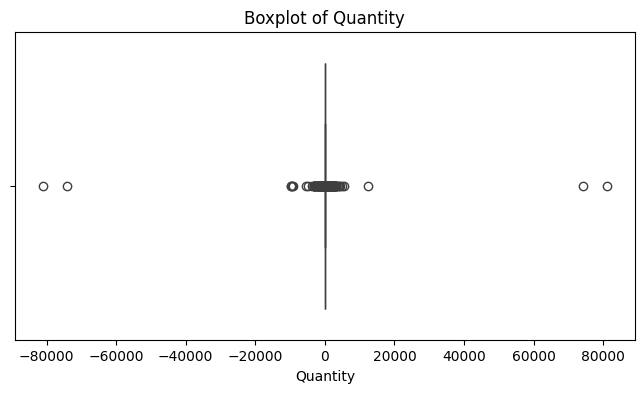

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Quantity'])
plt.title('Boxplot of Quantity')
plt.xlabel('Quantity')
plt.show()

## 2-2. Unit Price

- First of all, we can create a new feature - TotalPrice by multiplying quantity and unit price.
- While the UnitPrice values between the 25th and 75th percentiles appear reasonable, the maximum value of 38,987 seems questionable. Referring to the boxplot, this value clearly stands out as an outlier.

In [ ]:
df["UnitPrice"].quantile([0.25, 0.5, 0.75, 1])

,UnitPrice
0.25,1.25
0.50,2.08
0.75,4.13
1.00,38970.00


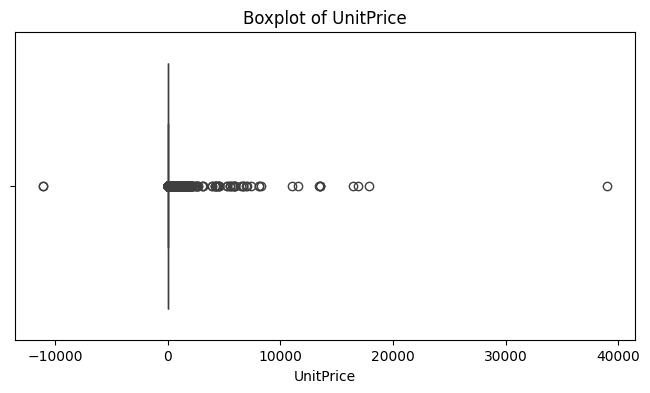

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['UnitPrice'])
plt.title('Boxplot of UnitPrice')
plt.xlabel('UnitPrice')
plt.show()

- Let's take a closer look at these values. Referring to the table below, the rows with unusually high UnitPrice values tend to have irregular StockCode, negative Quantity, InvoiceNo starting with characters like 'C' or 'B', and some null values in CustomerID.
- Based on this observation, it appears that InvoiceNo Starting with 'C' and negative Quantity may indicate canceled transactions. These should be considered important features during data preprocessing.
- Such anomalies - like negative quantities and canceled invoices - may contribute to abnormal UnitPrice values. Therefore, we will re-evaluate the UnitPrice statistics after appropriate data cleaning and preprocessing.

In [ ]:
df.sort_values(by='UnitPrice', ascending=False).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,6/10/2011 15:31,38970.00,15098.0,United Kingdom
524602,C580605,AMAZONFEE,AMAZON FEE,-1,12/5/2011 11:36,17836.46,NaN,United Kingdom
43702,C540117,AMAZONFEE,AMAZON FEE,-1,1/5/2011 9:55,16888.02,NaN,United Kingdom
43703,C540118,AMAZONFEE,AMAZON FEE,-1,1/5/2011 9:57,16453.71,NaN,United Kingdom
16356,C537651,AMAZONFEE,AMAZON FEE,-1,12/7/2010 15:49,13541.33,NaN,United Kingdom
15016,C537630,AMAZONFEE,AMAZON FEE,-1,12/7/2010 15:04,13541.33,NaN,United Kingdom
15017,537632,AMAZONFEE,AMAZON FEE,1,12/7/2010 15:08,13541.33,NaN,United Kingdom
16232,C537644,AMAZONFEE,AMAZON FEE,-1,12/7/2010 15:34,13474.79,NaN,United Kingdom
524601,C580604,AMAZONFEE,AMAZON FEE,-1,12/5/2011 11:35,11586.50,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,8/12/2011 14:50,11062.06,NaN,United Kingdom


In [ ]:
df[df['Quantity'] > 0]['UnitPrice'].quantile([0.25, 0.5, 0.75, 1])

,UnitPrice
0.25,1.25
0.50,2.08
0.75,4.13
1.00,13541.33


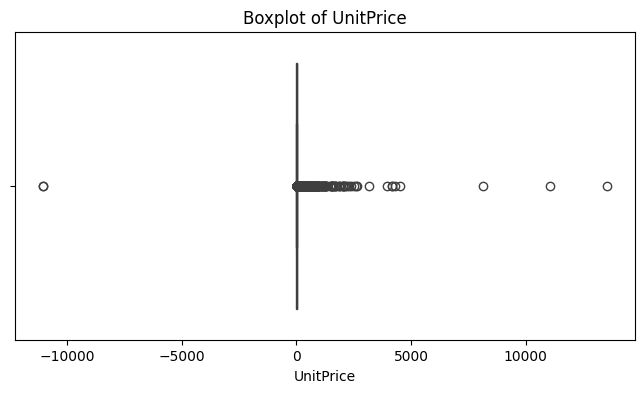

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df[df['Quantity'] > 0]['UnitPrice'])
plt.title('Boxplot of UnitPrice')
plt.xlabel('UnitPrice')
plt.show()

In [ ]:
df[df['Quantity']>0].sort_values(by='UnitPrice', ascending=False).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
15017,537632,AMAZONFEE,AMAZON FEE,1,12/7/2010 15:08,13541.33,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,8/12/2011 14:50,11062.06,NaN,United Kingdom
173382,551697,POST,POSTAGE,1,5/3/2011 13:46,8142.75,16029.0,United Kingdom
297723,562955,DOT,DOTCOM POSTAGE,1,8/11/2011 10:14,4505.17,NaN,United Kingdom
268028,560373,M,Manual,1,7/18/2011 12:30,4287.63,NaN,United Kingdom
422376,573080,M,Manual,1,10/27/2011 14:20,4161.06,12536.0,France
422351,573077,M,Manual,1,10/27/2011 14:13,4161.06,12536.0,France
406406,571751,M,Manual,1,10/19/2011 11:18,3949.32,12744.0,Singapore
374542,569382,M,Manual,1,10/3/2011 16:44,3155.95,15502.0,United Kingdom
347948,567353,M,Manual,1,9/19/2011 16:14,2653.95,NaN,Hong Kong


## 2-3. CustomerID

- While we have unique 4,372 customers, this column contains a significanlt number of null values. To visualize this, I'll create a plot showing the count of null versus non-null entries

In [ ]:
df['CustomerID'].nunique()

4372

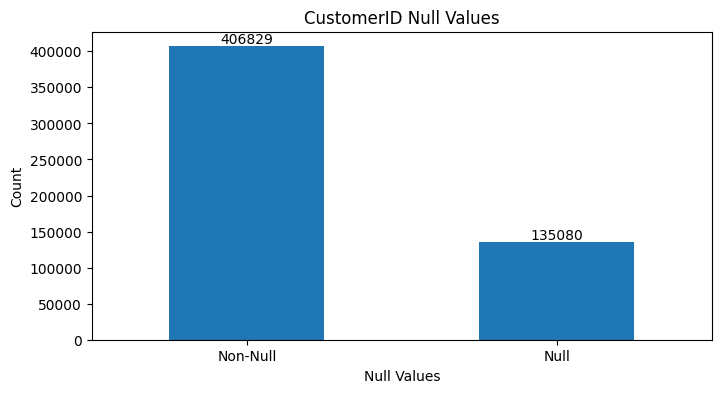

In [ ]:
# Count null and non-null values
customer_null_counts = df['CustomerID'].isnull().value_counts()
customer_null_counts.index = ['Non-Null', 'Null']

# Add labels of value on top of bars
def add_value(x, y):
  for i in range(len(x)):
    plt.text(i, y[i], y[i], ha='center', va='bottom')


# Create a bar plot
plt.figure(figsize=(8,4))
customer_null_counts.plot(kind='bar')
plt.title('CustomerID Null Values')
plt.xlabel('Null Values')
plt.ylabel('Count')
plt.xticks(rotation=0)

add_value(customer_null_counts.index, customer_null_counts.values)

plt.show()

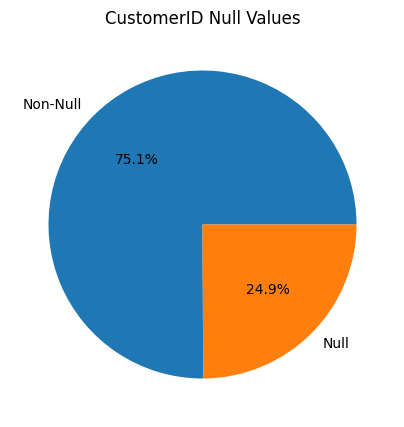

In [ ]:
# Creating a pie chart to identify how many % are null values in CustomerID

fig = plt.figure(figsize = (5, 5))
plt.pie(customer_null_counts, labels = customer_null_counts.index, autopct='%1.1f%%')
plt.title('CustomerID Null Values')
plt.show()

- As shown above, there are total of 135,080 null values in the CustomerID column. Since CustomerID serves as a unique identifier for each row, retaining null values in this column could lead to inaccurate analysis or misleading results. Therefore, I'll remove all rows that contain null values in the CustomerID column.

----------

Inference for Categorical Values

In [ ]:
# statistical info for categorical values

df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


## 2-4. Inovice No

- Previously, we observed that there's odds in InvoiceNo, starting with a letter, while most InvoiceNo starts with a number.
- Referring to the tables below, a total 9,291 rows starting with a letter, 3 of them start with A, others start with C which indicates canceled items. This canceled item can be used to identify which items are canceled, and an indicator of the cancellation rates of the item.

In [ ]:
# Filter rows where the InvoiceNo starts with a letter

df[~df['InvoiceNo'].astype(str).str.match(r'^\d')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


## 2-5. Stock Code

- We have 4,070 unique values in StockCode, which means we have a total of 4,070 unique items in the catalog.
- However, the StockCode column contains inconsistencies. While most values are five digit numbers and sometimes with a letter, some entries are shorter numeric codes or consist of only a single letter, indicating irregular formatting or non-standard product identifiers.
- Since accurately identifying each item is essential for this study, rows with invalid or incomplete StockCode values will be removed, as they do not provide reliable item information.

In [ ]:
# Count the number of characters in StockCode

df['StockCode'].str.len().value_counts()

,count
StockCode,
5,487036
6,51488
4,1276
1,715
3,710
7,390
2,144
12,71
9,48


In [ ]:
df[~df['StockCode'].astype(str).str.len().isin([5, 6])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,12/1/2010 8:45,18.00,12583.0,France
132,536381,15056BL,EDWARDIAN PARASOL BLACK,2,12/1/2010 9:41,5.95,15311.0,United Kingdom
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
281,536396,15056BL,EDWARDIAN PARASOL BLACK,6,12/1/2010 10:51,4.95,17850.0,United Kingdom
386,536403,POST,POSTAGE,1,12/1/2010 11:27,15.00,12791.0,Netherlands
...,...,...,...,...,...,...,...,...
541540,581498,DOT,DOTCOM POSTAGE,1,12/9/2011 10:26,1714.17,NaN,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541730,581570,POST,POSTAGE,1,12/9/2011 11:59,18.00,12662.0,Germany
541767,581574,POST,POSTAGE,2,12/9/2011 12:09,18.00,12526.0,Germany


In [ ]:
df[df["StockCode"].astype(str).str.len() == 7]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
132,536381,15056BL,EDWARDIAN PARASOL BLACK,2,12/1/2010 9:41,5.95,15311.0,United Kingdom
281,536396,15056BL,EDWARDIAN PARASOL BLACK,6,12/1/2010 10:51,4.95,17850.0,United Kingdom
1219,536531,15056BL,EDWARDIAN PARASOL BLACK,12,12/1/2010 13:23,5.95,15485.0,United Kingdom
4164,536750,15056BL,EDWARDIAN PARASOL BLACK,6,12/2/2010 14:04,4.95,17850.0,United Kingdom
4185,536752,15056BL,EDWARDIAN PARASOL BLACK,6,12/2/2010 14:06,4.95,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
533673,581098,15056BL,EDWARDIAN PARASOL BLACK,6,12/7/2011 11:42,5.95,14911.0,EIRE
536407,581219,15056BL,EDWARDIAN PARASOL BLACK,1,12/8/2011 9:28,12.46,NaN,United Kingdom
536964,581232,15056BL,EDWARDIAN PARASOL BLACK,24,12/8/2011 10:26,5.95,12358.0,Austria
541223,581495,15056BL,EDWARDIAN PARASOL BLACK,36,12/9/2011 10:20,5.95,14051.0,United Kingdom


In [ ]:
df[df["StockCode"].astype(str).str.len() > 7]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4406,536779,BANK CHARGES,Bank Charges,1,12/2/2010 15:08,15.00,15823.0,United Kingdom
14435,C537572,BANK CHARGES,Bank Charges,-1,12/7/2010 12:00,95.38,NaN,United Kingdom
14514,C537600,AMAZONFEE,AMAZON FEE,-1,12/7/2010 12:41,1.00,NaN,United Kingdom
15016,C537630,AMAZONFEE,AMAZON FEE,-1,12/7/2010 15:04,13541.33,NaN,United Kingdom
15017,537632,AMAZONFEE,AMAZON FEE,1,12/7/2010 15:08,13541.33,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
518711,580115,DCGSSBOY,BOYS PARTY BAG,1,12/1/2011 16:22,3.29,NaN,United Kingdom
524601,C580604,AMAZONFEE,AMAZON FEE,-1,12/5/2011 11:35,11586.50,NaN,United Kingdom
524602,C580605,AMAZONFEE,AMAZON FEE,-1,12/5/2011 11:36,17836.46,NaN,United Kingdom
534008,581127,BANK CHARGES,Bank Charges,1,12/7/2011 12:45,15.00,16271.0,United Kingdom


## 2-6. Description

- After reviewing the data, description column states the name of products, which can be identified by StockCode column.

In [ ]:
df[df["StockCode"]=='23090']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
190711,553205,23090,VINTAGE GLASS T-LIGHT HOLDER,12,2011-05-16 08:13:00,0.83,15813.0,United Kingdom
195617,553730,23090,VINTAGE GLASS T-LIGHT HOLDER,144,2011-05-19 07:49:00,0.72,16525.0,United Kingdom
196281,553833,23090,VINTAGE GLASS T-LIGHT HOLDER,2,2011-05-19 11:41:00,0.83,17346.0,United Kingdom
196612,553857,23090,VINTAGE GLASS T-LIGHT HOLDER,12,2011-05-19 13:30:00,0.83,NaN,Unspecified
196640,553859,23090,VINTAGE GLASS T-LIGHT HOLDER,12,2011-05-19 13:35:00,0.83,14505.0,United Kingdom
...,...,...,...,...,...,...,...,...
531754,580964,23090,VINTAGE GLASS T-LIGHT HOLDER,24,2011-12-06 14:50:00,0.83,15822.0,United Kingdom
532798,580997,23090,VINTAGE GLASS T-LIGHT HOLDER,12,2011-12-06 17:23:00,0.83,15023.0,United Kingdom
533726,581104,23090,VINTAGE GLASS T-LIGHT HOLDER,12,2011-12-07 12:11:00,0.83,13668.0,United Kingdom
534391,581146,23090,VINTAGE GLASS T-LIGHT HOLDER,24,2011-12-07 13:53:00,0.83,17602.0,United Kingdom


## 2-7. Country

In [ ]:
df['Country'].value_counts(normalize=True).head(10)

,proportion
Country,
United Kingdom,0.914320
Germany,0.017521
France,0.015790
EIRE,0.015124
Spain,0.004674
Netherlands,0.004375
Belgium,0.003818
Switzerland,0.003694
Portugal,0.002803


## 2-8. InvoiceDate

- Convert InvoiceDate to datetime format to identify its seasonal effect and execute further time-series analysis

- bar plot - purchases by month for top 4 countries. bar plot split by each countries. 전체 플랏도 하나 더
=> check seasonality. seasonal effects.

In [ ]:
# Convert InoviceDate to datetime format

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [ ]:
print(f"Earliest date: {df['InvoiceDate'].min()}")
print(f"Latest date: {df['InvoiceDate'].max()}")

Earliest date: 2010-12-01 08:26:00
Latest date: 2011-12-09 12:50:00


In [ ]:
df["InvoiceDate"].dt.month.value_counts().sort_index()

,count
InvoiceDate,
1,35147
2,27707
3,36748
4,29916
5,37030
6,36874
7,39518
8,35284
9,50226


#3. Data Pre-Processing

## 3-1. Missing Values

As shown above, 24.9% in CustomrID column are null. Since CustomerID is essential for customer segmentation and constructing the user-item matrix, all rows with missing values in this column will be removed. Additionally, records with anomalous or inconsistent values often lack a CustomerID. Therefore, removing rows with null values in this column may also elo eliminate these irregular entries from the dataset.

In [ ]:
df = df.dropna(subset=['CustomerID'])

In [ ]:
df.isnull().sum().sum()

np.int64(0)

## 3-2. Duplicated Values

Given the characteristic of e commerce sales data, it doesn't appear to be reasonable if one person make several transactions which is exactly same at same moment. Thus, I'll remove those duplicated rows.

In [ ]:
df[df.duplicated(keep=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [ ]:
df[df.duplicated(keep=False)].sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'CustomerID'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
440149,C574510,22360,GLASS JAR ENGLISH CONFECTIONERY,-1,11/4/2011 13:25,2.95,15110.0,United Kingdom
461407,C575940,23309,SET OF 60 I LOVE LONDON CAKE CASES,-24,11/13/2011 11:38,0.55,17838.0,United Kingdom
461408,C575940,23309,SET OF 60 I LOVE LONDON CAKE CASES,-24,11/13/2011 11:38,0.55,17838.0,United Kingdom
529980,C580764,22667,RECIPE BOX RETROSPOT,-12,12/6/2011 10:38,2.95,14562.0,United Kingdom


In [ ]:
df.duplicated().sum()

np.int64(5268)

In [ ]:
df.drop_duplicates(inplace=True)

<ipython-input-72-16cdb8520be8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


In [ ]:
df.duplicated().sum()

np.int64(0)

## 3-3. Canceled Items - Negative Quantity

- Identifying which items are frequently canceled and which customers tend to make cancellations can enhance customer segmentation. This insight may also guide customers in making more informed purchasing decisions in the future. Thus, a new column will be added to indicate whether a transaction is canceled: 1 denotes a cancellation, while 0 indicates it was not canceled.
- Not only adding the new column indicationg cancellation, but also a new column will be created to capture each customer's cancellation rate. This will help identify individual customer behavior patterns related to cancellations.

In [ ]:
# Canceled transactions

df[df['InvoiceNo'].astype(str).str.startswith('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,12/9/2011 9:57,1.95,14397.0,United Kingdom
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [ ]:
# Create a new column identifying cancellation

df['Canceled'] = np.where(df['Quantity'] < 0, 1, 0)

In [ ]:
df[df['Canceled'] == 1].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,1
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,1
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,1
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,1


## 3-4. Unit Price Anomalies

In [ ]:
df['UnitPrice'].describe()

,UnitPrice
count,399701.000000
mean,2.907783
std,4.452269
min,0.000000
25%,1.250000
50%,1.950000
75%,3.750000
max,649.500000


In [ ]:
print(f"There are {df['UnitPrice'].value_counts()[0]} rows with UnitPrice is 0")

There are 33 rows with UnitPrice is 0


In [ ]:
df[df['UnitPrice'] == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647.0,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560.0,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911.0,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,1/13/2011 15:10,0.0,15107.0,United Kingdom,0
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2/10/2011 13:08,0.0,17560.0,United Kingdom,0
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,3/23/2011 10:25,0.0,13239.0,United Kingdom,0
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,3/30/2011 12:45,0.0,13113.0,United Kingdom,0
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,4/4/2011 14:42,0.0,14410.0,United Kingdom,0


In [ ]:
def unit_price_fill(df):

  unit_zero_df = df[df['UnitPrice'] == 0]
  unit_zero_index = unit_zero_df.index.to_numpy()
  unit_zero_stockcode = unit_zero_df['StockCode'].unique()

  # Create a list container with the average unit price for unique stock codes
  unit_price_list = []

  for i in unit_zero_stockcode:
    df_tmp = df[df['UnitPrice'] != 0]
    unit_price_list.append(df_tmp[df_tmp['StockCode'] == i]['UnitPrice'].mean().round(2))

  # Fill in the zero unit price to the average unit price calculated above
  df.loc[unit_zero_index, 'UnitPrice'] = unit_price_list

  return df

In [ ]:
unit_price_fill(df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,0


In [ ]:
df['UnitPrice'].describe()

,UnitPrice
count,399701.000000
mean,2.908095
std,4.452294
min,0.001000
25%,1.250000
50%,1.950000
75%,3.750000
max,649.500000


In [ ]:
df.shape

(399701, 10)

## 3-5. StockCode Anormalies

In [ ]:
df = df[df['StockCode'].astype(str).str.len().isin([5, 6, 7])]

In [ ]:
df.shape

(399689, 10)

# 4. Feature Engineering

## 4-1. Total Unit Price

In [ ]:
df['TotalUnit'] = df['Quantity'] * df['UnitPrice']

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled,TotalUnit
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0,20.34


## 4-2. RFM Features

- Recency - The freshness of the customer activity, be it purchases or visits. (e.g. Time since last order or last engaged with the product)

- Frequency - The frequency of the customer transactions or visits. (e.g. Total number of transactions or average time between transactions/engaged visits)

- Monetary - The intention of customer to spend or purchasing power of customer (e.g. Total or average transactions value)

### 4-2-1. Recency

1) Date_Of_Last_Purchase
\
2) Days_From_Last_Purchase

In [ ]:
customer_df = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
customer_df = customer_df.rename(columns={'InvoiceDate': 'Date_Of_Last_Purchase'})
customer_df

,CustomerID,Date_Of_Last_Purchase
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-12-07 15:52:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00
...,...,...
4358,18280.0,2011-03-07 09:52:00
4359,18281.0,2011-06-12 10:53:00
4360,18282.0,2011-12-02 11:43:00
4361,18283.0,2011-12-06 12:02:00


In [ ]:
customer_df['Days_From_Last_Purchase'] = (df['InvoiceDate'].max() - customer_df['Date_Of_Last_Purchase']).dt.days

In [ ]:
customer_df.head()

,CustomerID,Date_Of_Last_Purchase,Days_From_Last_Purchase
0,12346.0,2011-01-18 10:17:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309


### 4-2-2. Frequency

1) Total_Transaction
\
2) Total_Products

In [ ]:
# Create Total_Transactions Column
Total_Transaction = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
Total_Transaction = Total_Transaction.rename(columns = {'InoviceNo':'Total_Transactions'})

# Create Total_Products Column
Total_Products = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
Total_Products = Total_Products.rename(columns = {'StockCode': 'Total_Products'})

# Merge data frames
customer_df = customer_df.merge(Total_Transaction, on='CustomerID', how = 'left')
customer_df = customer_df.merge(Total_Products, on = 'CustomerID', how = 'left')

customer_df

,CustomerID,Date_Of_Last_Purchase,Days_From_Last_Purchase,InvoiceNo,Total_Products
0,12346.0,2011-01-18 10:17:00,325,2,1
1,12347.0,2011-12-07 15:52:00,1,7,103
2,12348.0,2011-09-25 13:13:00,74,4,21
3,12349.0,2011-11-21 09:51:00,18,1,72
4,12350.0,2011-02-02 16:01:00,309,1,16
...,...,...,...,...,...
4358,18280.0,2011-03-07 09:52:00,277,1,10
4359,18281.0,2011-06-12 10:53:00,180,1,7
4360,18282.0,2011-12-02 11:43:00,7,3,12
4361,18283.0,2011-12-06 12:02:00,3,16,262


### 4-2-3. Monetary

1) Total_Spend

In [ ]:
Total_Spend = df.groupby('CustomerID')['TotalUnit'].sum().reset_index()
Total_Spend = Total_Spend.rename(columns = {'TotalUnit': 'Total_Spend'})

customer_df = customer_df.merge(Total_Spend, on = 'CustomerID', how = 'left')

customer_df

,CustomerID,Date_Of_Last_Purchase,Days_From_Last_Purchase,InvoiceNo,Total_Products,Total_Spend
0,12346.0,2011-01-18 10:17:00,325,2,1,0.00
1,12347.0,2011-12-07 15:52:00,1,7,103,4310.00
2,12348.0,2011-09-25 13:13:00,74,4,21,1437.24
3,12349.0,2011-11-21 09:51:00,18,1,72,1457.55
4,12350.0,2011-02-02 16:01:00,309,1,16,294.40
...,...,...,...,...,...,...
4358,18280.0,2011-03-07 09:52:00,277,1,10,180.60
4359,18281.0,2011-06-12 10:53:00,180,1,7,80.82
4360,18282.0,2011-12-02 11:43:00,7,3,12,176.60
4361,18283.0,2011-12-06 12:02:00,3,16,262,2039.58


## 4-3. Behavioral Features

1) Unique_Products: How many unique products
\
2) Highest_Spend

In [53]:
# Create Unique_Products
Unique_Products = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
Unique_Products = Unique_Products.rename(columns = {'StockCode': 'Unique_Products'})

# Create Highest_Spend
Highest_Spend = df.groupby('CustomerID')['TotalUnit'].max().reset_index()
Highest_Spend = Highest_Spend.rename(columns = {'TotalUnit' : 'Highest_Spend'})


# Merge data frames
customer_df = customer_df.merge(Unique_Products, on = 'CustomerID', how = 'left')
customer_df = customer_df.merge(Highest_Spend, on = 'CustomerID', how = 'left')

In [56]:
customer_df.shape

(4363, 10)

## 4-4. Average Days Between Purchase

To properly calculate the average number of days between purchases, it is important to retain only unique InvoiceNo values. When customers buy multiple items in a single transaction, each item generates a separate row with the same invoice number and date, which can disrupt the calculation of exact mean values. For example, referring to the table below, CustomerID '18282' appears to have an average interval of 9.83 days between purchases. However, this customer made only three unique transactions on 08/05/2011, 08/09/2011, and 12/02/2011, which can't be 9.833 days of average interval. Thus, only one record per unique InvoiceNo will be reatined to make sure a correct calculation of purchase intervals.

In [58]:
df.groupby('CustomerID')['InvoiceDate'].diff().dt.days.groupby(df['CustomerID']).mean()

,InvoiceDate
CustomerID,
12346.0,0.000000
12347.0,2.000000
12348.0,10.846154
12349.0,0.000000
12350.0,0.000000
...,...
18280.0,0.000000
18281.0,0.000000
18282.0,9.833333


In [59]:
df[df['CustomerID'] == 18282]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled,TotalUnit
291854,562525,21270,ANTIQUE CREAM CUTLERY CUPBOARD,1,2011-08-05 13:35:00,12.75,18282.0,United Kingdom,0,12.75
291855,562525,23187,FRENCH STYLE STORAGE JAR BONBONS,48,2011-08-05 13:35:00,0.29,18282.0,United Kingdom,0,13.92
291856,562525,23295,SET OF 12 MINI LOAF BAKING CASES,8,2011-08-05 13:35:00,0.83,18282.0,United Kingdom,0,6.64
291857,562525,22089,PAPER BUNTING VINTAGE PAISLEY,6,2011-08-05 13:35:00,2.95,18282.0,United Kingdom,0,17.70
291858,562525,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,9,2011-08-05 13:35:00,2.55,18282.0,United Kingdom,0,22.95
291859,562525,21109,LARGE CAKE TOWEL CHOCOLATE SPOTS,2,2011-08-05 13:35:00,6.75,18282.0,United Kingdom,0,13.50
291860,562525,22424,ENAMEL BREAD BIN CREAM,1,2011-08-05 13:35:00,12.75,18282.0,United Kingdom,0,12.75
295686,C562808,23187,FRENCH STYLE STORAGE JAR BONBONS,-5,2011-08-09 15:10:00,0.29,18282.0,United Kingdom,1,-1.45
519825,580173,22423,REGENCY CAKESTAND 3 TIER,2,2011-12-02 11:43:00,12.75,18282.0,United Kingdom,0,25.50
519826,580173,22699,ROSES REGENCY TEACUP AND SAUCER,6,2011-12-02 11:43:00,2.95,18282.0,United Kingdom,0,17.70


In [61]:
# Returning unique InvoiceNo

df_single_invodate = df.drop_duplicates(subset=['InvoiceNo']).reset_index()

In [62]:
df_single_invodate[df_single_invodate['CustomerID'] == 18282]

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled,TotalUnit
12378,291854,562525,21270,ANTIQUE CREAM CUTLERY CUPBOARD,1,2011-08-05 13:35:00,12.75,18282.0,United Kingdom,0,12.75
12527,295686,C562808,23187,FRENCH STYLE STORAGE JAR BONBONS,-5,2011-08-09 15:10:00,0.29,18282.0,United Kingdom,1,-1.45
21069,519825,580173,22423,REGENCY CAKESTAND 3 TIER,2,2011-12-02 11:43:00,12.75,18282.0,United Kingdom,0,25.50


In [97]:
df_purchase_between_days = df_single_invodate.groupby('CustomerID')['InvoiceDate'].diff().dt.days.groupby(df_single_invodate['CustomerID']).mean().reset_index()
df_purchase_between_days = df_purchase_between_days.rename(columns = {'InvoiceDate': 'Average_Days_Between_Purchase'})
customer_df = customer_df.merge(df_purchase_between_days, on = 'CustomerID', how='left')

customer_df.head()

,CustomerID,Date_Of_Last_Purchase,Days_From_Last_Purchase,InvoiceNo,Total_Products,Total_Spend,Average_Days_Between_Purchase
0,12346.0,2011-01-18 10:17:00,325,2,1,0.00,0.000000
1,12347.0,2011-12-07 15:52:00,1,7,103,4310.00,60.333333
2,12348.0,2011-09-25 13:13:00,74,4,21,1437.24,94.000000
3,12349.0,2011-11-21 09:51:00,18,1,72,1457.55,NaN
4,12350.0,2011-02-02 16:01:00,309,1,16,294.40,NaN


However, if a customer has made only single transaction, it is not possible to compute the interval between purchases due to the absence of a subsequent transaction. In such case, the time since that purchase can be estimated by calculating the difference between the most recen transaction date in the dataset and the customer's transaction date, which can be the same as Days_From_Last_Purchases.

In [64]:
df_single_invodate[df_single_invodate['CustomerID'] == 12349]

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled,TotalUnit
19847,485502,577609,23112,PARISIENNE CURIO CABINET,2,2011-11-21 09:51:00,7.5,12349.0,Italy,0,15.0


In [67]:
df_purchase_between_days[df_purchase_between_days['InvoiceDate'].isna()]

,CustomerID,InvoiceDate
3,12349.0,NaN
4,12350.0,NaN
6,12353.0,NaN
7,12354.0,NaN
8,12355.0,NaN
...,...,...
4341,18256.0,NaN
4346,18262.0,NaN
4357,18278.0,NaN
4358,18280.0,NaN


Also, if customers canceled the transaction, the purchase between days would be calculated as 0, which makes no sense.

In [108]:
customer_df['Average_Days_Between_Purchase'].replace(0, np.nan, inplace=True)
customer_df['Average_Days_Between_Purchase'].fillna(customer_df['Days_From_Last_Purchase'], inplace=True)
customer_df.head()

,CustomerID,Date_Of_Last_Purchase,Days_From_Last_Purchase,InvoiceNo,Total_Products,Total_Spend,Average_Days_Between_Purchase
0,12346.0,2011-01-18 10:17:00,325.0,2,1,0.00,325.000000
1,12347.0,2011-12-07 15:52:00,1.0,7,103,4310.00,60.333333
2,12348.0,2011-09-25 13:13:00,74.0,4,21,1437.24,94.000000
3,12349.0,2011-11-21 09:51:00,18.0,1,72,1457.55,18.000000
4,12350.0,2011-02-02 16:01:00,309.0,1,16,294.40,309.000000


## 4-5. Cancellation Features

1) Cancellation_Experience
\
2) Cancellation_Rate


In [ ]:
df_canceled = df.groupby('CustomerID')['Canceled'].sum().reset_index()

In [ ]:
df_canceled.rename(columns = {'Canceled': 'Cancellation_Total'}, inplace = True)
df_canceled['Cancellation_Experience'] = np.where(df_canceled['Cancellation_Total'] > 0, 1, 0)

customer_df = customer_df.merge(df_canceled, on = 'CustomerID', how = 'left')
customer_df['Cancellation_Rate'] = customer_df['Cancellation_Total'] / customer_df['Total_Transactions']

In [133]:
customer_df.drop(columns = ['Cancellation_Total'], inplace = True)

In [134]:
customer_df

,CustomerID,Date_Of_Last_Purchase,Days_From_Last_Purchase,Total_Transactions,Total_Products,Total_Spend,Average_Days_Between_Purchase,Cancellation_Experience,Cancellation_Rate
0,12346.0,2011-01-18 10:17:00,325.0,2,1,0.00,325.000000,1,0.500000
1,12347.0,2011-12-07 15:52:00,1.0,7,103,4310.00,60.333333,0,0.000000
2,12348.0,2011-09-25 13:13:00,74.0,4,21,1437.24,94.000000,0,0.000000
3,12349.0,2011-11-21 09:51:00,18.0,1,72,1457.55,18.000000,0,0.000000
4,12350.0,2011-02-02 16:01:00,309.0,1,16,294.40,309.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...
4358,18280.0,2011-03-07 09:52:00,277.0,1,10,180.60,277.000000,0,0.000000
4359,18281.0,2011-06-12 10:53:00,180.0,1,7,80.82,180.000000,0,0.000000
4360,18282.0,2011-12-02 11:43:00,7.0,3,12,176.60,59.000000,1,0.333333
4361,18283.0,2011-12-06 12:02:00,3.0,16,262,2039.58,21.800000,0,0.000000


## 4-6. Country Features

1) UK_OR_NOT

## 4-7. Statistical Features

1) Monthly_Spend_Mean
\
2) Monthly_Spend_STD

## 4-8. Outlier Detection

# 5. Building a Model - Clustering